In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.plot import draw_raster_single
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real

In [2]:
def get_power1(Gamma):
    return Gamma[:,0,0].real

def get_power1dB(Gamma):
    return 10*np.log10(Gamma[:,0,0].real)

def get_coh(Gamma):
    return thr_coherence(Gamma)


from cohlib.utils import conv_v_to_z
def Gamma_est_from_zs(zs, dc=True):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

In [3]:
mu = 0.0
K = 2
L = 25 
C = 1
sample_length = 1000
seed = 7
ov1 = 1.0


In [4]:
def scale_construct_real_idft_mod(slen, J, J_max, fs, dc=False, order='standard'):
    if dc is True:
        Jv_max = int(J_max * 2) + 2
    else:
        Jv_max = int(J_max * 2)

    Wv = np.zeros((slen, Jv_max))
    for t in range(slen):
        if dc is True:
            for j in range(J_max + 1):
                Wv[t, 2 * j] = np.cos((t + 1) * np.pi * j / (J + 1))
                Wv[t, 2 * j + 1] = -np.sin(((t + 1) * np.pi * j) / (J + 1))
        else:
            for j in range(1, J_max + 1):
                Wv[t, 2 * (j - 1)] = np.cos((t + 1) * np.pi * j / (J + 1))
                Wv[t, 2 * (j - 1) + 1] = -np.sin((t + 1) * np.pi * j / (J + 1))
    # Wv = Wv * ((2 * np.pi) / (J + 1))
    Wv = Wv 
    if dc is True:
        Wv = np.delete(Wv, 1, 1)

    if order == "standard":
        pass
    elif order == "real-imag":
        if dc is True:
            raise NotImplementedError
        else:
            re_filt = np.arange(Wv.shape[1]) % 2 == 0
            im_filt = np.arange(Wv.shape[1]) % 2 == 1
            Wv_re = Wv[:, re_filt]
            Wv_im = Wv[:, im_filt]
            Wv_ri = np.concatenate([Wv_re, Wv_im], axis=1)
            Wv = Wv_ri
    else:
        raise ValueError
    return Wv 

In [5]:
import os
import jax.numpy as jnp
import jax.random as jr
from cohlib.utils import gamma_root
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import add0


lseed = 7
oseed = 7
flow = 1
fhigh = 50
sp_target = 5
sp_offtarget = 1
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
N = freqs.size
nz = gamma_load['nonzero_inds']
nz_target = jnp.array([9])
K = gamma_full.shape[-1]

lrk = jr.key(lseed)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

# ork = jr.key(oseed)


# print(f"Sampling observations with variance {ov1}e^{ov2}")
# obs_var = ov1 * 10**ov2
# # obs_var = ocfg.ov1 * 10**{ocfg.ov2}
# jax_ys = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)
# ys = np.array(jax_ys)[:,None,:,:]

In [6]:
# import jax
# from cohlib.jax.dists import sample_ccn
# from functools import partial
# gamma = gamma_full
# N = gamma.shape[0]

# # samples = jnp.stack([sample_ccn(lrk, gamma[n,:,:], L) for n in range(N)])
# rksplit = jr.split(lrk,N)
# samples2 = jnp.stack([sample_ccn(rksplit[n], gamma[n,:,:], L) for n in range(N)])



In [9]:
xs.shape

(1000, 2, 25)

In [11]:
ov2 = -1.0



seed = 8
etype="approx"
model_path = f'saved/fitted_models/jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
model_load = pickle_open(model_path)

Wv_model = model_load['Wv']
Wv = Wv_model
num_J_vars = Wv.shape[1]
freqs_mod = freqs[:int((Wv.shape[1]) / 2)]

J_max = int((Wv.shape[1])/2)


In [17]:
zs0 = zs[nz,0,:]

In [20]:
from cohlib.utils import conv_z_to_v
vs0 = conv_z_to_v(zs0, axis=0)

In [39]:
xs_old = Wv @ vs0
xs_old.shape

J = 500
Wv_mod = Wv * (1 / (2 * np.pi))
xs_old_mod = Wv_mod @ vs0

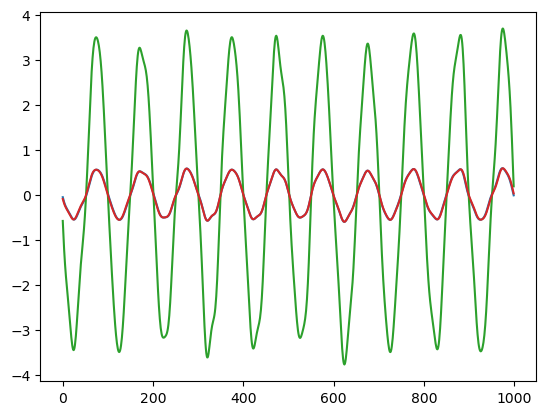

In [43]:
for i in range(1):
    plt.plot(xs[:,0,i], color='tab:blue')
    plt.plot(xs_old[:,i], color='tab:green')
    plt.plot(xs_old_mod[:,i], color='tab:red')

In [181]:
# from cohlib.mvcn import sample_mvcn_time_obs_nodc
# data_check_path = f'saved/synthetic_data/simple_synthetic_gaussian_2_25_1000_1_0.0_1.0_0.0_7' 
# check = pickle_open(data_check_path)
# nz = np.arange(50)
# Gamma_reduce = check['latent']['Gamma'][nz,:,:]
# freqs_reduce = freqs[nz]
# Wv_reduce = Wv

# check_xs, check_vs, check_zs = sample_mvcn_time_obs_nodc(Gamma_reduce, L, freqs_reduce, Wv_reduce, return_all=True)
# # S = check['latent']['Gamma'][:,0,0].real
# # plt.plot(S)
# # # plt.ylim([0,500])
# # plt.xlim([0,50])

In [182]:
# test = Wv.T @ ys[:,0,0,0]
vs_from_ys = jnp.einsum('jt,tkl->jkl', Wv.T, ys[:,0,:,:])
zs_from_ys = conv_v_to_z(vs_from_ys, axis=0)
gamma_from_ys = jnp.einsum('jkl,jil->jkil', zs_from_ys, zs_from_ys.conj()).mean(-1)

Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
# zs_naive = jnp.fft.rfft(ys, axis=0)[1:,0,:,:]
# gamma_naive = jnp.einsum('jkl,jil->jkil', zs_naive, zs_naive.conj()).mean(-1)

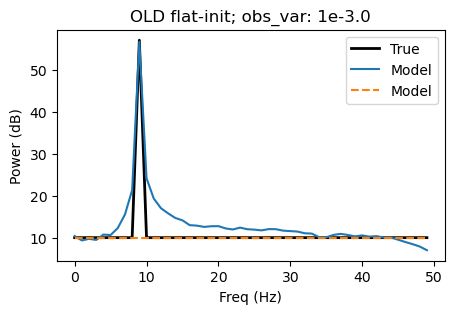

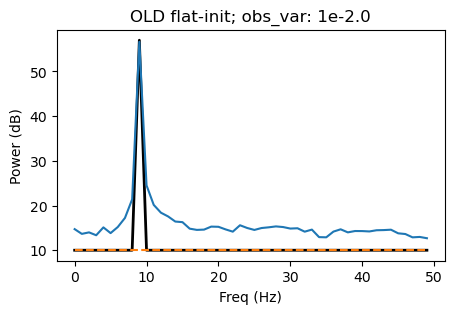

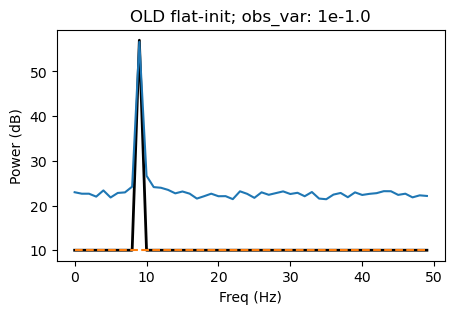

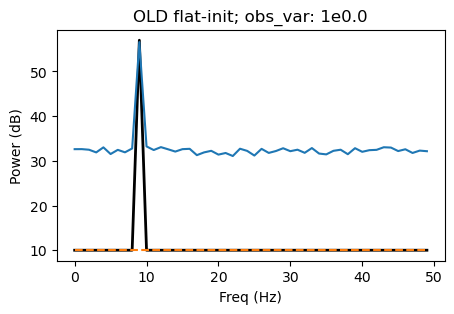

In [25]:
dB = True
ov2 = -1.0
seed = 8
etype="approx"
ovs = [-3, -2, -1, 0]
for ov2 in ovs:
    ov2 = float(ov2)
    model_path = f'saved/fitted_models/jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_load = pickle_open(model_path)

    fig, ax = plt.subplots(figsize=(5,3))
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
    J = 500
    S_model = model_load['Gamma'][:,0,0].real * ((2*J )**2 * (np.pi / (J + 1))**2)
    S_init = Gamma_init[:,0,0].real 
    S_true = gamma_full[:50,0,0].real 
    # S_naive = gamma_from_ys[:,0,0].real * (((J * np.pi)**2 / (J + 1)))

    if dB is True:
        S_model = 10*np.log10(S_model)
        S_init = 10*np.log10(S_init)
        # S_naive = 10*np.log10(S_naive)
        S_true = 10*np.log10(S_true)

    ax.plot(S_true, 'k', linewidth=2, label='True')
    # ax.plot(S_oracle, 'tab:green', label='Oracle')
    ax.plot(S_model, 'tab:blue', label='Model')
    ax.plot(S_init, 'tab:orange', linestyle='--', label='Model')
    ax.set_title(f'OLD flat-init; obs_var: 1e{ov2}')
    ax.set_xlabel('Freq (Hz)')
    if dB is True:
        ax.set_ylabel('Power (dB)')
    else:
        ax.set_ylabel('Power ')
    if ov2 == -3:
        ax.legend()
    # plt.xlim([0,5])